### PINN approach for the 1-D duffing problem

$\ddot{u} + 2D\dot{u} + \omega_0^2(u + \mu u^3) = f(t)$

In [113]:
import torch
import torch.nn as nn
import torchphysics as tp
import pytorch_lightning as pl
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from torchinfo import summary

import matplotlib.pyplot as plt

In [114]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print('Training on', device)
print ("GPU available: " + str(torch.cuda.is_available()))

Training on cuda:1
GPU available: True


In [115]:
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False

In [116]:
omega_0 = 1

ode_params = {'D': .1,      # damping constant
              'c_nlin': 0.75  # nonlinearity
             }
sampling_frequency = 32 
t_end = 36 # sec
time = np.linspace(0, t_end, t_end*sampling_frequency + 1)
time_ind = pd.to_timedelta(time, unit="sec")
f_fac = 0.75
x0 = [0, 0] # initial conditions [x0, v0]

### ODE solution

In [117]:
def duffing(t, y, D, c_nlin, F_func):
    z1, z2 = y
    dz1dt = z2
    dz2dt = - 2 * D * z2 - z1 - c_nlin * z1**3 + f_fac *  F_func(t)
    return(dz1dt, dz2dt)

F = pd.Series(np.random.randn(time.shape[0]),
              index=pd.Index(time, name="time")
              )# some white noise data on right hand site
F_inter_func = IUS(time, F, k=1)

numeric_solu = solve_ivp(duffing,
                         t_span=(0, t_end),
                         y0 = x0,
                         max_step=1 / sampling_frequency,
                         args=(ode_params['D'], ode_params['c_nlin'], F_inter_func)
                        )

solu = pd.Series(numeric_solu.y[0,:], index=pd.Index(numeric_solu.t, name="time"), name="Runge-Kutta")

<AxesSubplot:title={'center':'Right hand site f(t)'}, xlabel='time'>

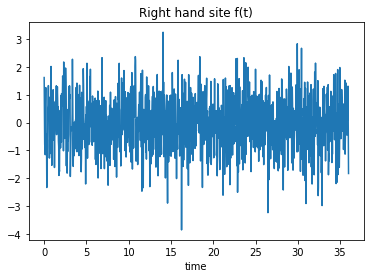

In [118]:
%matplotlib inline
F.plot(title="Right hand site f(t)")

<AxesSubplot:title={'center':'Runge-Kutta'}, xlabel='time'>

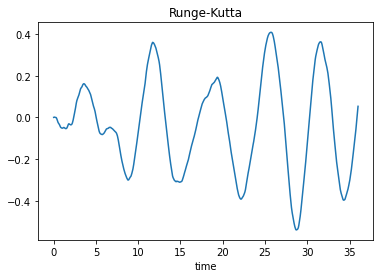

In [119]:
solu.plot(title="Runge-Kutta")

### PINN solution

In [120]:
T = tp.spaces.R1('t') # time
# Output
U = tp.spaces.R1('u')
# Intervals and domains and sampler
Dmin, Dmax = 0.01, 0.1
A_t = tp.domains.Interval(T, 0, t_end)
inner_sampler = tp.samplers.GridSampler(A_t, n_points = 2048)#.make_static()
    
initial_u_sampler = tp.samplers.GridSampler(A_t.boundary_left, n_points = 1).make_static()
initial_v_sampler = tp.samplers.GridSampler(A_t.boundary_left, n_points = 1).make_static()

<AxesSubplot:title={'center':'Right hand site f(t)'}, xlabel='time'>

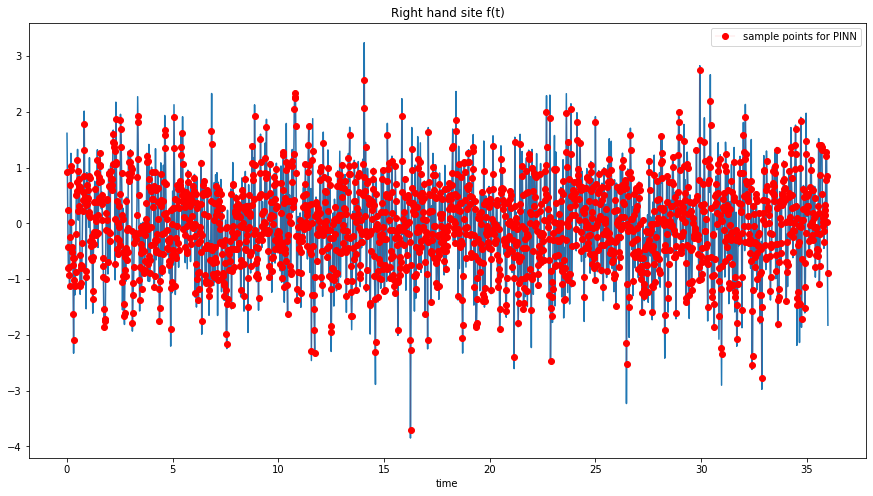

In [121]:
f, ax = plt.subplots(figsize=(15,8))
F.plot(title="Right hand site f(t)", ax=ax)
pd.DataFrame(F_inter_func(inner_sampler.sample_points().as_tensor.numpy().ravel()),
          index=pd.Index(inner_sampler.sample_points().as_tensor.numpy().ravel(),name="time"),
          columns=["sample points for PINN"]).plot(
              # x="time", y="sample points for PINN",
              marker="o",
              color="r",
              linestyle=None,
              linewidth=0.1,
               ax=ax
              )

In [122]:
#%% Model Definition
class Snake(torch.nn.Module):
    def __init__(self):
        super().__init__()
        pass

    def forward(self, Tensor):
        a = 1
        return Tensor + (1.0/a) * torch.pow(torch.sin(Tensor * a), 2)

class Sine(nn.Module):
    def __init__(self):
        super().__init__()
        pass

    def forward(self, Tensor):
        return torch.sin(Tensor)
    
class DampedSine(nn.Module):
    def __init__(self):
        super().__init__()
        pass

    def forward(self, Tensor):
        alpha = 0.1
        return torch.exp(-alpha * Tensor) * torch.sin(Tensor)

model = tp.models.FCN(input_space=T, output_space=U, hidden=(16, 16, 8, 6, 4),
                      activations=DampedSine() #Tanh(), RNN()
#                       activations=[Snake(), Snake(), Snake()] #Tanh(), RNN()
                      
                      )


# model = tp.models.Sequential(
#     tp.models.NormalizationLayer(A_t),
#     tp.models.FCN(input_space=T, output_space=U, hidden=(32,32, 16),
#                   activations=Sine())
# )
model  
summary(model, input_size=None)

Layer (type:depth-idx)                   Param #
FCN                                      --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       32
│    └─DampedSine: 2-2                   --
│    └─Linear: 2-3                       272
│    └─DampedSine: 2-4                   --
│    └─Linear: 2-5                       136
│    └─DampedSine: 2-6                   --
│    └─Linear: 2-7                       54
│    └─DampedSine: 2-8                   --
│    └─Linear: 2-9                       28
│    └─DampedSine: 2-10                  --
│    └─Linear: 2-11                      5
Total params: 527
Trainable params: 527
Non-trainable params: 0

In [123]:
def right_hand_side(t):
    rhs = f_fac * torch.tensor(F_inter_func(t.detach().cpu().numpy()))
    return rhs.cuda()

def duffing_residual(u, t, right_hand_side):
    pde_homo = tp.utils.laplacian(u, t)  + 2 * ode_params["D"] * tp.utils.grad(u, t) \
            + u + ode_params["c_nlin"] * u**3 #- right_hand_side(t)
    return pde_homo - right_hand_side 
            
pde_condition = tp.conditions.PINNCondition(module=model,
                                            sampler=inner_sampler,
                                            residual_fn=duffing_residual,
                                            data_functions={'right_hand_side': right_hand_side},
                                            name='pde_condition',
                                            weight=10.0)

def initial_u_residual(u):
    return u - x0[0]
initial_u_condition = tp.conditions.PINNCondition(module=model,
                                                     sampler=initial_u_sampler,
                                                     residual_fn=initial_u_residual,
                                                     name='ic_u')

def initial_v_residual(u, t):
    return tp.utils.grad(u, t) - x0[1]
initial_v_condition = tp.conditions.PINNCondition(module=model,
                                                     sampler=initial_v_sampler,
                                                     residual_fn=initial_v_residual,
                                                     name='ic_v')
def rhs_residual(u, right_hand_side):
    return right_hand_side - u

rhs_condition = tp.conditions.PINNCondition(module=model,
                                    sampler=inner_sampler,
                                    residual_fn=rhs_residual,
                                    data_functions={'right_hand_side': right_hand_side},
                                    name='rhs',
                                    weight=25)

In [124]:
gpus_switch = 1 if torch.cuda.is_available() else None
gpus_switch
#%% Training
for opti, steps in zip([torch.optim.AdamW, torch.optim.LBFGS], [5000, 240]):
    opt_setting = tp.solver.OptimizerSetting(opti, lr=1e-2) #AdamW, SGD, LBFGS
    solver = tp.solver.Solver([pde_condition,
                               initial_u_condition,
                               initial_v_condition,
#                                rhs_condition
                              ], optimizer_setting = opt_setting)
    
    trainer = pl.Trainer(gpus=gpus_switch,
                         max_steps = steps,
                         logger=True, 
                         benchmark=False,
                         log_every_n_steps=10,
                         )
    trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-bf355ce4-05d3-bb64-9bee-4f04b006a8ae/5/0]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 527   
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
527       Trainable params
0         Non-trainable params
527       Total params
0.002     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/krd2rng/.conda/envs/pytorch-physics/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/krd2rng/.conda/envs/pytorch-physics/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

/home/krd2rng/.conda/envs/pytorch-physics/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-bf355ce4-05d3-bb64-9bee-4f04b006a8ae/5/0]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 527   
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
527       Trainable params
0         Non-trainable params
527       Total params
0.002     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

<AxesSubplot:xlabel='time'>

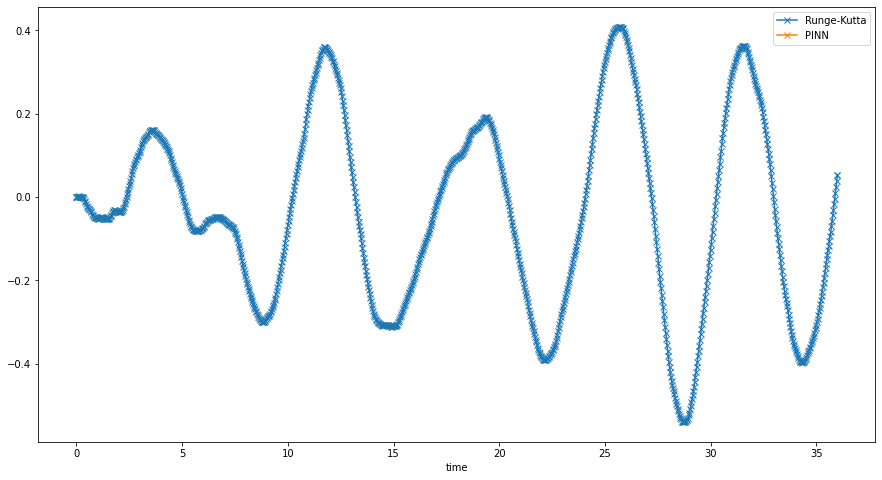

In [125]:
#%% Prediction
time_tensor = torch.tensor(time)

grid_sampler = tp.samplers.GridSampler(A_t, n_points=len(solu)) #+ tp.samplers.GridSampler(A_t.boundary, n_points=1)
grid_points = grid_sampler.sample_points()
                        # )
model_out = model(grid_points)
pinn_solu = pd.Series(np.interp(solu.index, grid_points.as_tensor.detach().numpy().ravel(), 
                                model_out.as_tensor.detach().numpy().ravel()),
                      index=solu.index, name="PINN"
                     )
solu_comb = pd.concat((solu, pinn_solu), axis=1)
solu_comb.plot(marker="x", figsize=(15,8))